In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;</style>"))
import os 
%load_ext autoreload
%autoreload 2
os.chdir("..")

from numerics.integration.matrices import *
from numerics.utilities.misc import *
import tensorflow as tf
from numerics.machine_learning.models import * 
import matplotlib.pyplot as plt 


/tmp/ipykernel_329038/476666071.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from numerics.machine_learning.misc import *

In [12]:
params, exp_path = def_params()
total_time = 10.
dt = 1e-3
xi, kappa, omega, eta = params

total_time,dt = total_time*kappa, kappa*dt
states_si, dys_si = load(itraj=1, exp_path=exp_path, total_time=total_time, dt=dt, ext_signal=1)

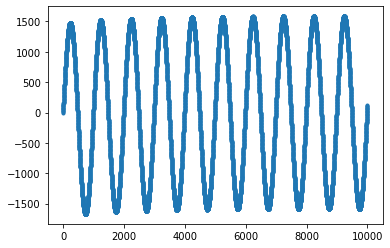

In [27]:
plt.plot(states_si[:,0],'.', linewidth=.3)

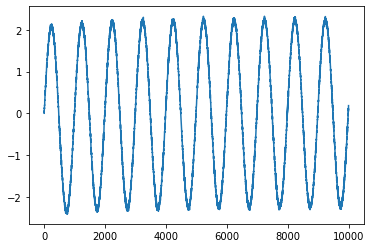

In [28]:
plt.plot(dys_si[:,0])

In [15]:
params, exp_path = def_params()
xi, kappa, omega, eta = params

T = 10.
dt = 1e-3

total_time,dt = T*kappa, kappa*dt


states_si, dys_si = load(itraj=1, exp_path=exp_path, total_time=total_time, dt=dt, ext_signal=1)

times = get_time(total_time,dt).astype(np.float32)
dd = tf.unstack(dys_si.astype(np.float32),axis=1)

tfsignals = tf.stack([times[:-1],dd[0], dd[1]])
tfsignals = tf.transpose(tfsignals)[tf.newaxis]

2022-05-18 20:58:34.463345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 20:58:34.485253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 20:58:34.485354: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-18 20:58:34.485617: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [29]:
params, exp_path = def_params()

initial_parameters = np.array([10., 4*2*np.pi/total_time]).astype(np.float32)
true_parameters = np.array([10., 4*2*np.pi/total_time]).astype(np.float32)


A, D , E, B  = genoni_matrices(*params)
xicov, covss = genoni_xi_cov(A,D, E, B ,params, stat=True)

BS = len(tfsignals[0])
batch_shape = [BS, None, 3]
model = Model(params=params, dt=dt, initial_parameters=initial_parameters,
              true_parameters=true_parameters, initial_states = np.zeros((1,5)).astype(np.float32),
              cov_in=covss, batch_size=tuple([None,None,3]))#tuple(batch_shape))
model.recurrent_layer.build(tf.TensorShape(batch_shape))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))



In [36]:
model.reset_states()
model.trainable_variables[0].assign(tf.convert_to_tensor(np.array([[ 1e4, 2*np.pi ]]).astype(np.float32)))


<tf.Variable 'UnreadVariable' shape=(1, 2) dtype=float32, numpy=array([[1.0000000e+04, 6.2831855e+00]], dtype=float32)>

In [37]:
preds = model.predict(tfsignals)

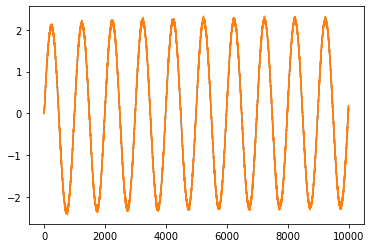

In [39]:
plt.plot(preds[0,:,0])
plt.plot(dys_si[:,0])

In [44]:
model.reset_states()
model.trainable_variables[0].assign(tf.convert_to_tensor(np.array([[ 1e5, 200*np.pi ]]).astype(np.float32)))
preds_b = model.predict(tfsignals)

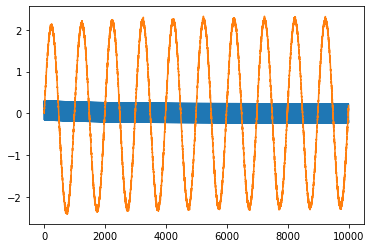

In [46]:
plt.plot(preds_b[0,:,0])
plt.plot(dys_si[:,0])

In [47]:
tf.keras.losses.mse(np.squeeze(tfsignals[:,:,1]), preds_b[0,:,0])

<tf.Tensor: shape=(), dtype=float32, numpy=2.5326579>

In [48]:
tf.keras.losses.mse(np.squeeze(tfsignals[:,:,1]), preds[0,:,0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.0010112431>

array([0., 2., 4., 6., 8.])

In [ ]:
amplitude = 1e4
omega = 2*np.pi

losses = {}
amps_les = np.linspace(1e4-1e3, 1e4+1e3, 5)
freqs_les = np.linspace(0,*np.pi, 5)#[0, 2*np.pi, 20*np.pi, 200*np.pi]
for amplitude in amps:
    for omega in freqs:
        model.reset_states()
        model.trainable_variables[0].assign(tf.convert_to_tensor(np.array([[ amplitude, omega ]]).astype(np.float32)))
        preds = model.predict(tfsignals)

        losses[str([amplitude, omega])] = tf.keras.losses.mse(np.squeeze(tfsignals[:,:,1]), preds[0,:,0])

In [25]:
amplitude = 1e4
omega = 2*np.pi

losses = {}
amps = [1e2, 1e3, 1e4, 1e5]
freqs = [0, 2*np.pi, 20*np.pi, 200*np.pi]
for amplitude in amps:
    for omega in freqs:
        model.reset_states()
        model.trainable_variables[0].assign(tf.convert_to_tensor(np.array([[ amplitude, omega ]]).astype(np.float32)))
        preds = model.predict(tfsignals)

        losses[str([amplitude, omega])] = tf.keras.losses.mse(np.squeeze(tfsignals[:,:,1]), preds[0,:,0])

In [49]:
lolo = np.reshape(np.squeeze(list(losses.values())), (4,4))

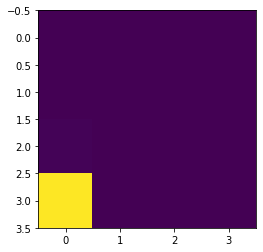

/tmp/ipykernel_329038/1830035973.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


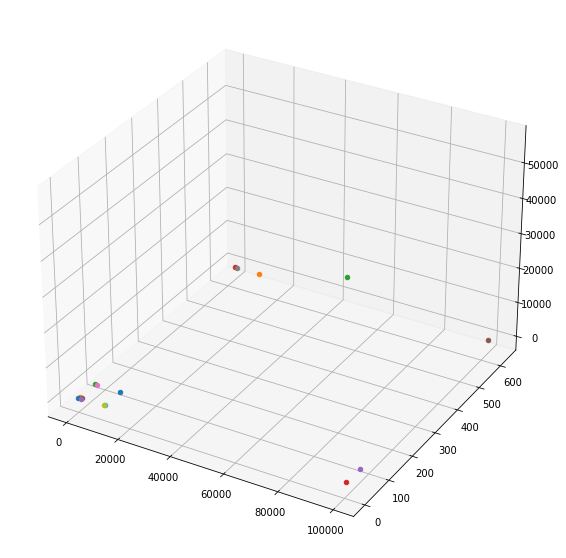

In [53]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
for a in amps:
    for f in freqs:
        ax.scatter(a,f,losses[str([a,f])])

In [6]:
save_dir = get_training_save_dir(exp_path, total_time, dt, itraj=1,train_id=2)
loss = np.load(save_dir+"loss.npy")
grads = np.load(save_dir+"grads.npy")
params = np.load(save_dir+"params.npy")

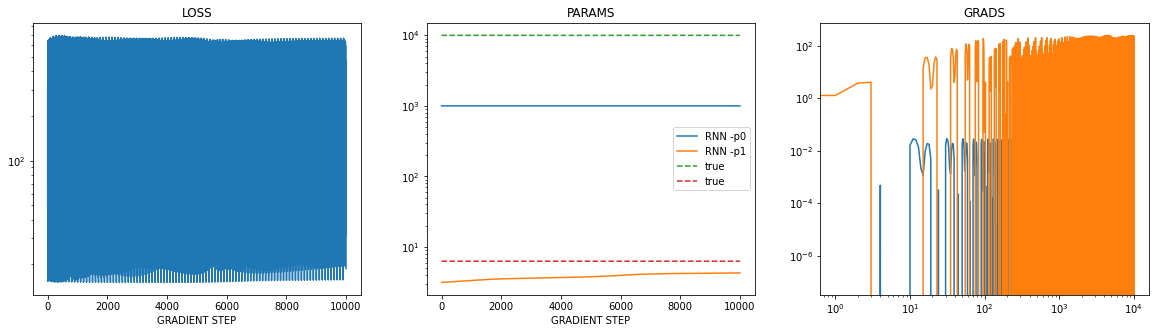

In [9]:

plot_history(data=[loss,params,grads], true_parameters=[1e4, 2*np.pi])

Note i'm fixing the amplitude so the plot above dismiss the amplitude, we only train frequencies

In [90]:
params, exp_path = def_params()

initial_parameters = np.array([1., 2*np.pi/10]).astype(np.float32)
true_parameters = np.array([10., 2*np.pi/10]).astype(np.float32)


A, D , E, B  = genoni_matrices(*params)
xicov, covss = genoni_xi_cov(A,D, E, B ,params, stat=True)

BS = len(tfsignals[0])
model = Model(params=params, dt=dt, initial_parameters=initial_parameters,
              true_parameters=true_parameters, cov_in=covss, batch_size=(BS,None,3))
model.recurrent_layer.build(tf.TensorShape([1,None,3]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1))

In [94]:
history = model.fit(x=tfsignals, y=tfsignals, batch_size=BS, epochs=300)

Epoch 1/300
1/1 [==============================] - 0s 60ms/step - LOSS: 75.5581 - PARAMS: 4.4503 - GRADS: -17.2870
Epoch 2/300
1/1 [==============================] - 0s 66ms/step - LOSS: 74.7908 - PARAMS: 4.4667 - GRADS: -16.8036
Epoch 3/300
1/1 [==============================] - 0s 63ms/step - LOSS: 74.0750 - PARAMS: 4.4827 - GRADS: -16.3304
Epoch 4/300
1/1 [==============================] - 0s 59ms/step - LOSS: 73.4077 - PARAMS: 4.4984 - GRADS: -15.8673
Epoch 5/300
1/1 [==============================] - 0s 61ms/step - LOSS: 72.7869 - PARAMS: 4.5138 - GRADS: -15.4140
Epoch 6/300
1/1 [==============================] - 0s 59ms/step - LOSS: 72.2102 - PARAMS: 4.5289 - GRADS: -14.9704
Epoch 7/300
1/1 [==============================] - 0s 66ms/step - LOSS: 71.6757 - PARAMS: 4.5436 - GRADS: -14.5365
Epoch 8/300
1/1 [==============================] - 0s 68ms/step - LOSS: 71.1817 - PARAMS: 4.5580 - GRADS: -14.1125
Epoch 9/300
1/1 [==============================] - 0s 61ms/step - LOSS: 70.7248 

Epoch 143/300
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6966 - PARAMS: 5.0328 - GRADS: -0.0022
Epoch 144/300
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6977 - PARAMS: 5.0328 - GRADS: -0.0013
Epoch 145/300
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6985 - PARAMS: 5.0328 - GRADS: -2.2298e-04
Epoch 146/300
1/1 [==============================] - 0s 61ms/step - LOSS: 70.6997 - PARAMS: 5.0328 - GRADS: 3.5781e-04
Epoch 147/300
1/1 [==============================] - 0s 64ms/step - LOSS: 70.7002 - PARAMS: 5.0329 - GRADS: 0.0012
Epoch 148/300
1/1 [==============================] - 0s 60ms/step - LOSS: 70.7011 - PARAMS: 5.0329 - GRADS: 0.0017
Epoch 149/300
1/1 [==============================] - 0s 63ms/step - LOSS: 70.7016 - PARAMS: 5.0329 - GRADS: 0.0023
Epoch 150/300
1/1 [==============================] - 0s 62ms/step - LOSS: 70.7022 - PARAMS: 5.0329 - GRADS: 0.0028
Epoch 151/300
1/1 [==============================] - 0s 61ms/step - L

1/1 [==============================] - 0s 63ms/step - LOSS: 70.6996 - PARAMS: 5.0328 - GRADS: -1.5944e-04
Epoch 282/300
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6997 - PARAMS: 5.0328 - GRADS: 7.6801e-05
Epoch 283/300
1/1 [==============================] - 0s 61ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 284/300
1/1 [==============================] - 0s 68ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 285/300
1/1 [==============================] - 0s 68ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 286/300
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 287/300
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 288/300
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 289/300
1/1 [==============================] - 0s 68ms/

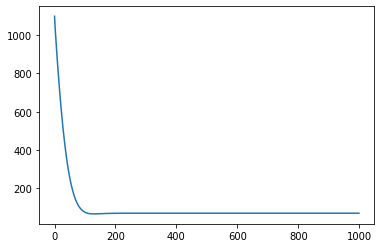

In [151]:
plt.plot(history.history["LOSS"])

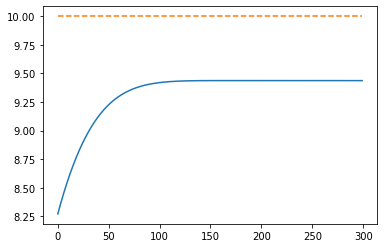

In [96]:
history_param = np.squeeze(history.history["PARAMS"])[:,0]
plt.plot(history_param)
plt.plot(np.ones(len(history_param))*true_parameters[0], '--')

In [109]:
preds = model(tfsignals)

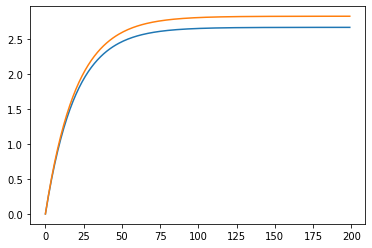

In [110]:

plt.plot(np.squeeze(preds)[:,0])
plt.plot(dd[0][:10000])

In [108]:
model.recurrent_layer.reset_states()

In [102]:
model.recurrent_layer.states

[<tf.Variable 'Variable:0' shape=(1, 5) dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>]

In [111]:
inputs = tfsignals
dys = tfsignals[:,:,1:] ###recall first entry is time, then signals
with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
    preds = model(inputs)
    diff = tf.squeeze(preds - dys)
    loss = tf.reduce_sum(tf.einsum('bj,bj->b',diff,diff))
grads = tape.gradient(loss, model.trainable_variables)
model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=401>

this shows that the gradient is very small !!! But what happens if we put some batch_size ?

[<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-242.99461,    0.     ]], dtype=float32)>]

In [114]:
params, exp_path = def_params()

initial_parameters = np.array([1., 2*np.pi/10]).astype(np.float32)
true_parameters = np.array([10., 2*np.pi/10]).astype(np.float32)


A, D , E, B  = genoni_matrices(*params)
xicov, covss = genoni_xi_cov(A,D, E, B ,params, stat=True)

BS = 25#len(tfsignals[0])
model = Model(params=params, dt=dt, initial_parameters=initial_parameters,
              true_parameters=true_parameters, cov_in=covss, batch_size=(BS,None,3))
model.recurrent_layer.build(tf.TensorShape([1,None,3]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1))

history = model.fit(x=tfsignals, y=tfsignals, batch_size=BS, epochs=300)

Epoch 1/300


/home/giq/.local/lib/python3.10/site-packages/keras/engine/training.py:2034: UserWarning: Metric Metrica implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


1/1 [==============================] - 0s 433ms/step - LOSS: 1097.7369 - PARAMS: 0.8642 - GRADS: -122.2767
Epoch 2/300
1/1 [==============================] - 0s 66ms/step - LOSS: 1060.5663 - PARAMS: 0.9141 - GRADS: -120.1352
Epoch 3/300
1/1 [==============================] - 0s 67ms/step - LOSS: 1035.5077 - PARAMS: 0.9641 - GRADS: -118.6959
Epoch 4/300
1/1 [==============================] - 0s 62ms/step - LOSS: 1010.7839 - PARAMS: 1.0140 - GRADS: -117.2574
Epoch 5/300
1/1 [==============================] - 0s 61ms/step - LOSS: 986.3987 - PARAMS: 1.0638 - GRADS: -115.8201
Epoch 6/300
1/1 [==============================] - 0s 63ms/step - LOSS: 962.3562 - PARAMS: 1.1136 - GRADS: -114.3841
Epoch 7/300
1/1 [==============================] - 0s 59ms/step - LOSS: 938.6615 - PARAMS: 1.1634 - GRADS: -112.9501
Epoch 8/300
1/1 [==============================] - 0s 61ms/step - LOSS: 915.3179 - PARAMS: 1.2130 - GRADS: -111.5180
Epoch 9/300
1/1 [==============================] - 0s 62ms/step - LOSS:

1/1 [==============================] - 0s 63ms/step - LOSS: 137.4928 - PARAMS: 3.7797 - GRADS: -36.9602
Epoch 72/300
1/1 [==============================] - 0s 62ms/step - LOSS: 133.6807 - PARAMS: 3.8080 - GRADS: -36.1327
Epoch 73/300
1/1 [==============================] - 0s 59ms/step - LOSS: 130.0292 - PARAMS: 3.8359 - GRADS: -35.3175
Epoch 74/300
1/1 [==============================] - 0s 62ms/step - LOSS: 126.5335 - PARAMS: 3.8633 - GRADS: -34.5147
Epoch 75/300
1/1 [==============================] - 0s 61ms/step - LOSS: 123.1878 - PARAMS: 3.8903 - GRADS: -33.7240
Epoch 76/300
1/1 [==============================] - 0s 61ms/step - LOSS: 119.9891 - PARAMS: 3.9169 - GRADS: -32.9456
Epoch 77/300
1/1 [==============================] - 0s 61ms/step - LOSS: 116.9314 - PARAMS: 3.9431 - GRADS: -32.1794
Epoch 78/300
1/1 [==============================] - 0s 61ms/step - LOSS: 114.0108 - PARAMS: 3.9688 - GRADS: -31.4252
Epoch 79/300
1/1 [==============================] - 0s 65ms/step - LOSS: 111.

1/1 [==============================] - 0s 63ms/step - LOSS: 70.5514 - PARAMS: 5.0284 - GRADS: -0.1363
Epoch 212/300
1/1 [==============================] - 0s 64ms/step - LOSS: 70.5614 - PARAMS: 5.0287 - GRADS: -0.1270
Epoch 213/300
1/1 [==============================] - 0s 62ms/step - LOSS: 70.5708 - PARAMS: 5.0290 - GRADS: -0.1182
Epoch 214/300
1/1 [==============================] - 0s 63ms/step - LOSS: 70.5797 - PARAMS: 5.0293 - GRADS: -0.1096
Epoch 215/300
1/1 [==============================] - 0s 59ms/step - LOSS: 70.5883 - PARAMS: 5.0295 - GRADS: -0.1016
Epoch 216/300
1/1 [==============================] - 0s 63ms/step - LOSS: 70.5964 - PARAMS: 5.0298 - GRADS: -0.0942
Epoch 217/300
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6039 - PARAMS: 5.0300 - GRADS: -0.0871
Epoch 218/300
1/1 [==============================] - 0s 61ms/step - LOSS: 70.6112 - PARAMS: 5.0302 - GRADS: -0.0804
Epoch 219/300
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6179 - PA

Epoch 282/300
1/1 [==============================] - 0s 65ms/step - LOSS: 70.7037 - PARAMS: 5.0329 - GRADS: 0.0037
Epoch 283/300
1/1 [==============================] - 0s 62ms/step - LOSS: 70.7035 - PARAMS: 5.0329 - GRADS: 0.0034
Epoch 284/300
1/1 [==============================] - 0s 62ms/step - LOSS: 70.7032 - PARAMS: 5.0329 - GRADS: 0.0034
Epoch 285/300
1/1 [==============================] - 0s 62ms/step - LOSS: 70.7032 - PARAMS: 5.0329 - GRADS: 0.0031
Epoch 286/300
1/1 [==============================] - 0s 62ms/step - LOSS: 70.7030 - PARAMS: 5.0329 - GRADS: 0.0031
Epoch 287/300
1/1 [==============================] - 0s 62ms/step - LOSS: 70.7029 - PARAMS: 5.0329 - GRADS: 0.0028
Epoch 288/300
1/1 [==============================] - 0s 62ms/step - LOSS: 70.7027 - PARAMS: 5.0329 - GRADS: 0.0028
Epoch 289/300
1/1 [==============================] - 0s 61ms/step - LOSS: 70.7026 - PARAMS: 5.0329 - GRADS: 0.0026
Epoch 290/300
1/1 [==============================] - 0s 62ms/step - LOSS: 70.702

In [118]:
model.reset_states()

In [119]:
preds = model(tfsignals)

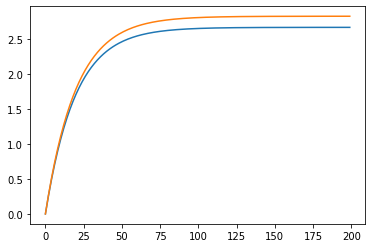

In [117]:
preds = model(tfsignals)
plt.plot(np.squeeze(preds)[:,0])
plt.plot(dd[0][:10000])

In [121]:
model.reset_states()

In [125]:
datas = tf.split(tfsignals, 8, axis=1)

In [128]:
def train_step(model, datas):
    inputs = tfsignals
    dys = tfsignals[:,:,1:] ###recall first entry is time, then signals
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        preds = model(inputs)
        diff = tf.squeeze(preds - dys)
        loss = tf.reduce_sum(tf.einsum('bj,bj->b',diff,diff))
    grads = tape.gradient(loss, model.trainable_variables)
    #model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, grads

In [130]:
train_step(model, datas[-1])

(<tf.Tensor: shape=(), dtype=float32, numpy=3.9907935>,
 [<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-14.709137,   0.      ]], dtype=float32)>])

In [131]:
train_step(model, datas[0])

(<tf.Tensor: shape=(), dtype=float32, numpy=70.6962>,
 [<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.00171471, 0.        ]], dtype=float32)>])

In [135]:
params, exp_path = def_params()

initial_parameters = np.array([1., 2*np.pi/10]).astype(np.float32)
true_parameters = np.array([10., 2*np.pi/10]).astype(np.float32)


A, D , E, B  = genoni_matrices(*params)
xicov, covss = genoni_xi_cov(A,D, E, B ,params, stat=True)

BS = 25#len(tfsignals[0])
model = Model(params=params, dt=dt, initial_parameters=initial_parameters,
              true_parameters=true_parameters, cov_in=covss, batch_size=(BS,None,3))
model.recurrent_layer.build(tf.TensorShape([1,None,3]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1))

history = model.fit(x=tfsignals, y=tfsignals, batch_size=BS, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 426ms/step - LOSS: 1097.7369 - PARAMS: 0.8642 - GRADS: -122.2767
Epoch 2/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 1060.5663 - PARAMS: 0.9141 - GRADS: -120.1352
Epoch 3/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 1035.5077 - PARAMS: 0.9641 - GRADS: -118.6959
Epoch 4/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 1010.7839 - PARAMS: 1.0140 - GRADS: -117.2574
Epoch 5/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 986.3987 - PARAMS: 1.0638 - GRADS: -115.8201
Epoch 6/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 962.3562 - PARAMS: 1.1136 - GRADS: -114.3841
Epoch 7/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 938.6615 - PARAMS: 1.1634 - GRADS: -112.9501
Epoch 8/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 915.3179 - PARAMS: 1.2130 - GRADS: -111.5180
Epoch 9/1000
1/1 [==============================] -

1/1 [==============================] - 0s 64ms/step - LOSS: 67.3001 - PARAMS: 4.8647 - GRADS: -5.0338
Epoch 140/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 67.3538 - PARAMS: 4.8709 - GRADS: -4.8501
Epoch 141/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 67.4114 - PARAMS: 4.8769 - GRADS: -4.6721
Epoch 142/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 67.4715 - PARAMS: 4.8827 - GRADS: -4.4993
Epoch 143/1000
1/1 [==============================] - 0s 66ms/step - LOSS: 67.5342 - PARAMS: 4.8883 - GRADS: -4.3315
Epoch 144/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 67.5997 - PARAMS: 4.8938 - GRADS: -4.1691
Epoch 145/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 67.6666 - PARAMS: 4.8991 - GRADS: -4.0115
Epoch 146/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 67.7356 - PARAMS: 4.9042 - GRADS: -3.8591
Epoch 147/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 67.8

1/1 [==============================] - 0s 61ms/step - LOSS: 70.7041 - PARAMS: 5.0329 - GRADS: 0.0042
Epoch 280/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.7040 - PARAMS: 5.0329 - GRADS: 0.0039
Epoch 281/1000
1/1 [==============================] - 0s 65ms/step - LOSS: 70.7038 - PARAMS: 5.0329 - GRADS: 0.0039
Epoch 282/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.7037 - PARAMS: 5.0329 - GRADS: 0.0037
Epoch 283/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.7035 - PARAMS: 5.0329 - GRADS: 0.0034
Epoch 284/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.7032 - PARAMS: 5.0329 - GRADS: 0.0034
Epoch 285/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.7032 - PARAMS: 5.0329 - GRADS: 0.0031
Epoch 286/1000
1/1 [==============================] - 0s 65ms/step - LOSS: 70.7030 - PARAMS: 5.0329 - GRADS: 0.0031
Epoch 287/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.7029 - PA

1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 417/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 418/1000
1/1 [==============================] - 0s 66ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 419/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 420/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 421/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 422/1000
1/1 [==============================] - 0s 65ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 423/1000
1/1 [==============================] - 0s 64ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 424/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 61ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 553/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 554/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 555/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 556/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 557/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 558/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 559/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 560/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 59ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 689/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 690/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 691/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 692/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 693/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 694/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 695/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 696/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 825/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 826/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 827/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 828/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 829/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 830/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 831/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 832/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 69ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 961/1000
1/1 [==============================] - 0s 64ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 962/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 963/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 964/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 965/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 966/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 967/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 968/1000
1/1 [==============================] - 0

In [136]:
model.reset_states()

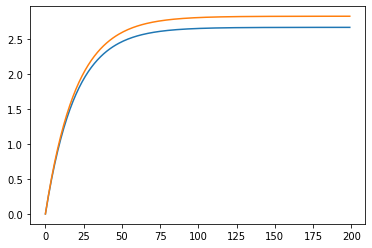

In [137]:
preds = model(tfsignals)
plt.plot(np.squeeze(preds)[:,0])
plt.plot(dd[0][:10000])

In [138]:
model.trainable_variables

[<tf.Variable 'gr_cell_15/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[9.437286  , 0.62831855]], dtype=float32)>]

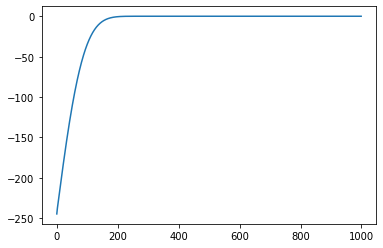

In [144]:
plt.plot(np.squeeze(history.history["GRADS"])[:,0])

In [145]:
params, exp_path = def_params()

initial_parameters = np.array([1., 2*np.pi/10]).astype(np.float32)
true_parameters = np.array([10., 2*np.pi/10]).astype(np.float32)


A, D , E, B  = genoni_matrices(*params)
xicov, covss = genoni_xi_cov(A,D, E, B ,params, stat=True)

BS = 1#25#len(tfsignals[0])
model = Model(params=params, dt=dt, initial_parameters=initial_parameters,
              true_parameters=true_parameters, cov_in=covss, batch_size=(BS,None,3))
model.recurrent_layer.build(tf.TensorShape([1,None,3]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1))

history = model.fit(x=tfsignals, y=tfsignals, batch_size=BS, epochs=1000)

Epoch 1/1000


/home/giq/.local/lib/python3.10/site-packages/keras/engine/training.py:2034: UserWarning: Metric Metrica implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


1/1 [==============================] - 1s 679ms/step - LOSS: 1097.7369 - PARAMS: 0.8642 - GRADS: -122.2767
Epoch 2/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 1060.5663 - PARAMS: 0.9141 - GRADS: -120.1352
Epoch 3/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 1035.5077 - PARAMS: 0.9641 - GRADS: -118.6959
Epoch 4/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 1010.7839 - PARAMS: 1.0140 - GRADS: -117.2574
Epoch 5/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 986.3987 - PARAMS: 1.0638 - GRADS: -115.8201
Epoch 6/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 962.3562 - PARAMS: 1.1136 - GRADS: -114.3841
Epoch 7/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 938.6615 - PARAMS: 1.1634 - GRADS: -112.9501
Epoch 8/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 915.3179 - PARAMS: 1.2130 - GRADS: -111.5180
Epoch 9/1000
1/1 [==============================] - 0s 57ms/step

1/1 [==============================] - 0s 60ms/step - LOSS: 67.3001 - PARAMS: 4.8647 - GRADS: -5.0338
Epoch 140/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 67.3538 - PARAMS: 4.8709 - GRADS: -4.8501
Epoch 141/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 67.4114 - PARAMS: 4.8769 - GRADS: -4.6721
Epoch 142/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 67.4715 - PARAMS: 4.8827 - GRADS: -4.4993
Epoch 143/1000
1/1 [==============================] - 0s 64ms/step - LOSS: 67.5342 - PARAMS: 4.8883 - GRADS: -4.3315
Epoch 144/1000
1/1 [==============================] - 0s 64ms/step - LOSS: 67.5997 - PARAMS: 4.8938 - GRADS: -4.1691
Epoch 145/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 67.6666 - PARAMS: 4.8991 - GRADS: -4.0115
Epoch 146/1000
1/1 [==============================] - 0s 65ms/step - LOSS: 67.7356 - PARAMS: 4.9042 - GRADS: -3.8591
Epoch 147/1000
1/1 [==============================] - 0s 64ms/step - LOSS: 67.8

1/1 [==============================] - 0s 63ms/step - LOSS: 70.7041 - PARAMS: 5.0329 - GRADS: 0.0042
Epoch 280/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.7040 - PARAMS: 5.0329 - GRADS: 0.0039
Epoch 281/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 70.7038 - PARAMS: 5.0329 - GRADS: 0.0039
Epoch 282/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 70.7037 - PARAMS: 5.0329 - GRADS: 0.0037
Epoch 283/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.7035 - PARAMS: 5.0329 - GRADS: 0.0034
Epoch 284/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.7032 - PARAMS: 5.0329 - GRADS: 0.0034
Epoch 285/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.7032 - PARAMS: 5.0329 - GRADS: 0.0031
Epoch 286/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.7030 - PARAMS: 5.0329 - GRADS: 0.0031
Epoch 287/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 70.7029 - PA

1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 417/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 418/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 419/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 420/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 421/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 422/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 423/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 424/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 553/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 554/1000
1/1 [==============================] - 0s 56ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 555/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 556/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 557/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 558/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 559/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 560/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 61ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 689/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 690/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 691/1000
1/1 [==============================] - 0s 57ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 692/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 693/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 694/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 695/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 696/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 825/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 826/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 827/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 828/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 829/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 830/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 831/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 832/1000
1/1 [==============================] - 0

1/1 [==============================] - 0s 59ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 961/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 962/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 963/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 964/1000
1/1 [==============================] - 0s 65ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 965/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 966/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 967/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 7.9185e-05
Epoch 968/1000
1/1 [==============================] - 0

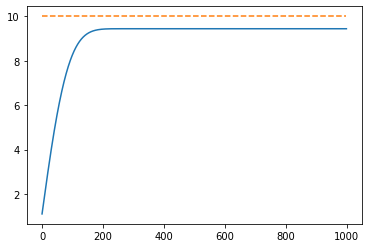

In [146]:
history_param = np.squeeze(history.history["PARAMS"])[:,0]
plt.plot(history_param)
plt.plot(np.ones(len(history_param))*true_parameters[0], '--')

In [148]:
model.reset_states()

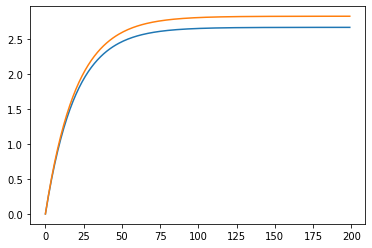

In [149]:
preds = model(tfsignals)
plt.plot(np.squeeze(preds)[:,0])
plt.plot(dd[0][:10000])

In [150]:
kappa

1

In [152]:
params, exp_path = def_params()

initial_parameters = np.array([10., 2*np.pi/10]).astype(np.float32)
true_parameters = np.array([10., 2*np.pi/10]).astype(np.float32)


A, D , E, B  = genoni_matrices(*params)
xicov, covss = genoni_xi_cov(A,D, E, B ,params, stat=True)

BS = 25#len(tfsignals[0])
model = Model(params=params, dt=dt, initial_parameters=initial_parameters,
              true_parameters=true_parameters, cov_in=covss, batch_size=(BS,None,3))
model.recurrent_layer.build(tf.TensorShape([1,None,3]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1))

history = model.fit(x=tfsignals, y=tfsignals, batch_size=BS, epochs=1000)

Epoch 1/1000
1/1 [==============================] - 0s 428ms/step - LOSS: 0.0266 - PARAMS: 5.2642 - GRADS: 0.3089
Epoch 2/1000
1/1 [==============================] - 0s 58ms/step - LOSS: 82.6110 - PARAMS: 5.2255 - GRADS: 6.7408
Epoch 3/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 80.0296 - PARAMS: 5.1820 - GRADS: 5.6089
Epoch 4/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 77.9217 - PARAMS: 5.1372 - GRADS: 4.3657
Epoch 5/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 75.8856 - PARAMS: 5.0929 - GRADS: 3.0779
Epoch 6/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 74.0660 - PARAMS: 5.0508 - GRADS: 1.8013
Epoch 7/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 72.5180 - PARAMS: 5.0127 - GRADS: 0.5847
Epoch 8/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 71.2547 - PARAMS: 4.9803 - GRADS: -0.5201
Epoch 9/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.2617 - PARA

1/1 [==============================] - 0s 62ms/step - LOSS: 70.8806 - PARAMS: 5.0383 - GRADS: 0.1742
Epoch 73/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.8808 - PARAMS: 5.0374 - GRADS: 0.1606
Epoch 74/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.8656 - PARAMS: 5.0361 - GRADS: 0.1334
Epoch 75/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.8361 - PARAMS: 5.0346 - GRADS: 0.0962
Epoch 76/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.7970 - PARAMS: 5.0331 - GRADS: 0.0534
Epoch 77/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.7524 - PARAMS: 5.0316 - GRADS: 0.0098
Epoch 78/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.7074 - PARAMS: 5.0305 - GRADS: -0.0311
Epoch 79/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6659 - PARAMS: 5.0296 - GRADS: -0.0654
Epoch 80/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6312 - PARAMS: 

1/1 [==============================] - 0s 60ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.2650e-04
Epoch 212/1000
1/1 [==============================] - 0s 65ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.2650e-04
Epoch 213/1000
1/1 [==============================] - 0s 65ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.2650e-04
Epoch 214/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.1542e-04
Epoch 215/1000
1/1 [==============================] - 0s 65ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 3.4994e-04
Epoch 216/1000
1/1 [==============================] - 0s 65ms/step - LOSS: 70.7001 - PARAMS: 5.0328 - GRADS: 7.3493e-05
Epoch 217/1000
1/1 [==============================] - 0s 65ms/step - LOSS: 70.6998 - PARAMS: 5.0328 - GRADS: -1.9574e-04
Epoch 218/1000
1/1 [==============================] - 0s 65ms/step - LOSS: 70.6995 - PARAMS: 5.0328 - GRADS: -4.8620e-04
Epoch 219/1000
1/1 [==============================] -

1/1 [==============================] - 0s 59ms/step - LOSS: 70.7002 - PARAMS: 5.0328 - GRADS: 6.2332e-04
Epoch 348/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.2650e-04
Epoch 349/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.2650e-04
Epoch 350/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.1542e-04
Epoch 351/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 3.4994e-04
Epoch 352/1000
1/1 [==============================] - 0s 64ms/step - LOSS: 70.7001 - PARAMS: 5.0328 - GRADS: -1.8594e-04
Epoch 353/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6995 - PARAMS: 5.0328 - GRADS: -4.8620e-04
Epoch 354/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6993 - PARAMS: 5.0328 - GRADS: -4.9117e-04
Epoch 355/1000
1/1 [==============================] 

1/1 [==============================] - 0s 64ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 3.6684e-04
Epoch 416/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.7002 - PARAMS: 5.0328 - GRADS: 6.2332e-04
Epoch 417/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.2650e-04
Epoch 418/1000
1/1 [==============================] - 0s 68ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.1542e-04
Epoch 419/1000
1/1 [==============================] - 0s 65ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 3.4994e-04
Epoch 420/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.7001 - PARAMS: 5.0328 - GRADS: 7.3493e-05
Epoch 421/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6998 - PARAMS: 5.0328 - GRADS: -1.9574e-04
Epoch 422/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6995 - PARAMS: 5.0328 - GRADS: -4.8620e-04
Epoch 423/1000
1/1 [==============================] -

1/1 [==============================] - 0s 61ms/step - LOSS: 70.6990 - PARAMS: 5.0328 - GRADS: -7.4679e-04
Epoch 552/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6990 - PARAMS: 5.0328 - GRADS: -7.3317e-04
Epoch 553/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6991 - PARAMS: 5.0328 - GRADS: -2.0057e-04
Epoch 554/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.6997 - PARAMS: 5.0328 - GRADS: 7.5996e-05
Epoch 555/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 6.1476e-04
Epoch 556/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.2650e-04
Epoch 557/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.2650e-04
Epoch 558/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.2650e-04
Epoch 559/1000
1/1 [==============================] 

1/1 [==============================] - 0s 60ms/step - LOSS: 70.7001 - PARAMS: 5.0328 - GRADS: 7.3493e-05
Epoch 688/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6998 - PARAMS: 5.0328 - GRADS: -4.7761e-04
Epoch 689/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.6993 - PARAMS: 5.0328 - GRADS: -4.9117e-04
Epoch 690/1000
1/1 [==============================] - 0s 64ms/step - LOSS: 70.6993 - PARAMS: 5.0328 - GRADS: -4.9117e-04
Epoch 691/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6993 - PARAMS: 5.0328 - GRADS: -4.9117e-04
Epoch 692/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.6993 - PARAMS: 5.0328 - GRADS: -4.7955e-04
Epoch 693/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6994 - PARAMS: 5.0328 - GRADS: 6.7562e-05
Epoch 694/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 3.6684e-04
Epoch 695/1000
1/1 [==============================

1/1 [==============================] - 0s 60ms/step - LOSS: 70.6994 - PARAMS: 5.0328 - GRADS: 6.7562e-05
Epoch 824/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.6999 - PARAMS: 5.0328 - GRADS: 6.1476e-04
Epoch 825/1000
1/1 [==============================] - 0s 63ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.2650e-04
Epoch 826/1000
1/1 [==============================] - 0s 61ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.2650e-04
Epoch 827/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 70.7004 - PARAMS: 5.0328 - GRADS: 6.1542e-04
Epoch 828/1000
1/1 [==============================] - 0s 62ms/step - LOSS: 70.7003 - PARAMS: 5.0328 - GRADS: 8.0526e-05
Epoch 829/1000
1/1 [==============================] - 0s 59ms/step - LOSS: 70.6998 - PARAMS: 5.0328 - GRADS: -1.9574e-04
Epoch 830/1000
1/1 [==============================] - 0s 64ms/step - LOSS: 70.6995 - PARAMS: 5.0328 - GRADS: -7.3445e-04
Epoch 831/1000
1/1 [==============================] -

1/1 [==============================] - 0s 62ms/step - LOSS: 70.6990 - PARAMS: 5.0328 - GRADS: -0.0010
Epoch 961/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 70.6987 - PARAMS: 5.0328 - GRADS: -0.0010
Epoch 962/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.6988 - PARAMS: 5.0328 - GRADS: -4.9117e-04
Epoch 963/1000
1/1 [==============================] - 0s 67ms/step - LOSS: 70.6994 - PARAMS: 5.0328 - GRADS: 3.4663e-04
Epoch 964/1000
1/1 [==============================] - 0s 66ms/step - LOSS: 70.7002 - PARAMS: 5.0328 - GRADS: 9.0447e-04
Epoch 965/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.7007 - PARAMS: 5.0328 - GRADS: 9.1872e-04
Epoch 966/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.7007 - PARAMS: 5.0328 - GRADS: 9.0209e-04
Epoch 967/1000
1/1 [==============================] - 0s 60ms/step - LOSS: 70.7006 - PARAMS: 5.0328 - GRADS: 3.5936e-04
Epoch 968/1000
1/1 [==============================] - 0s 66m

In [158]:
model.reset_states()

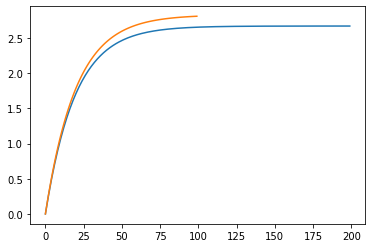

In [159]:
preds = model(tfsignals)
plt.plot(np.squeeze(preds)[:,0])
plt.plot(dd[0][:100])

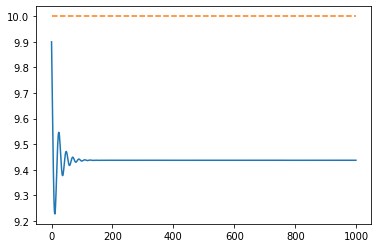

In [156]:
history_param = np.squeeze(history.history["PARAMS"])[:,0]
plt.plot(history_param)
plt.plot(np.ones(len(history_param))*true_parameters[0], '--')

In [160]:
params, exp_path = def_params()

initial_parameters = np.array([10., 2*np.pi/10]).astype(np.float32)
true_parameters = np.array([10., 2*np.pi/10]).astype(np.float32)


A, D , E, B  = genoni_matrices(*params)
xicov, covss = genoni_xi_cov(A,D, E, B ,params, stat=True)

BS = 25#len(tfsignals[0])
model = Model(params=params, dt=dt, initial_parameters=initial_parameters,
              true_parameters=true_parameters, cov_in=covss, batch_size=(BS,None,3))
model.recurrent_layer.build(tf.TensorShape([1,None,3]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1))



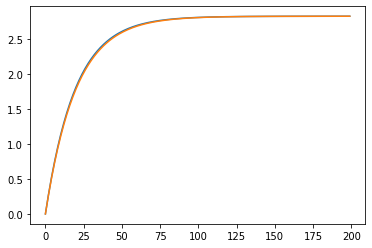

In [163]:
model.reset_states()
preds = model(tfsignals)
plt.plot(np.squeeze(preds)[:,0])
plt.plot(dd[0])

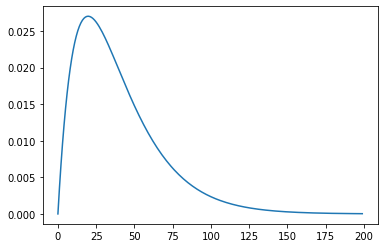

In [165]:
plt.plot(np.squeeze(preds)[:,0] - dd[0])

In [ ]:
model.trainable_variables[0]

In [166]:
def train_step(model, datas):
    inputs = tfsignals
    dys = tfsignals[:,:,1:] ###recall first entry is time, then signals
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        preds = model(inputs)
        diff = tf.squeeze(preds - dys)
        loss = tf.reduce_sum(tf.einsum('bj,bj->b',diff,diff))
    grads = tape.gradient(loss, model.trainable_variables)
    #model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, grads

In [172]:
model.trainable_variables[0].assign( tf.convert_to_tensor(np.array([[9.5, 0]]).astype(np.float32)))


<tf.Variable 'UnreadVariable' shape=(1, 2) dtype=float32, numpy=array([[9.5, 0. ]], dtype=float32)>

In [174]:
train_step(model, tfsignals)

(<tf.Tensor: shape=(), dtype=float32, numpy=79.40304>,
 [<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[2.5857966, 0.       ]], dtype=float32)>])

In [181]:
kappa

1

In [183]:
 tf.zeros( tuple([1]) + tuple([5]), dtype=np.float32)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[0., 0., 0., 0., 0.]], dtype=float32)>